In [1]:
import pandas as pd
import numpy as np
from gtfparse import read_gtf
import matplotlib.pyplot as plt
import bioframe as bf

from collections import defaultdict
rec_dd = lambda: defaultdict(rec_dd) #for initializing empty dictionarys


In [ ]:
# enhancers from chen
chenEnh = bf.read_table(
            '/project/fudenber_735/collaborations/karissa_2022/features/mm9/mESC_Enhancer_prediction_Chen12_BMCgenomics_mm9.bed',
           schema='bedGraph', skiprows=1)
chenEnh['score'] = chenEnh.value.str.replace(',','.').astype(float)
chenEnh['mid'] = (chenEnh.start + chenEnh.end)//2
chenEnh['mid2'] = (chenEnh.start + chenEnh.end)//2
chenEnh08 = chenEnh[chenEnh.score>=0.8].copy()
#  enhancers from whyte
allenh = pd.read_excel('/project/fudenber_735/collaborations/karissa_2022/features/mm9/NIHMS465689-supplement-02.xls', 
                  sheet_name='Supplemental_Table_S1',
                  header=2)
allenh['mid'] = (allenh.start + allenh.end) // 2
allenh['mid2'] = (allenh.start + allenh.end) // 2
normenh = allenh[allenh.isSuper=='NO']
superenh = allenh[allenh.isSuper=='YES']

In [25]:
## loading RNA counts from Nora supplemental table
RNA_seq_FPKM = pd.read_excel(
    '/project/fudenber_735/GEO/nora_2017_GSE98671_downloads/Elphege_2017/sup_data/NIHMS873912-supplement-10.xlsx', 
     skiprows=6, usecols="A:G, H:K, O:Q")
RNA_seq_FPKM.rename(columns={'tracking_id':'gene_id'}, inplace=True)
RNA_seq_FPKM[0:2]

In [29]:
# loading relevant TSS list
refseq_tss_df = read_gtf('/project/fudenber_735/genomes/mm9/RefSeq/tsses_from_mm9.refGene.gtf')
refseq_tss_df.drop_duplicates(['gene_id'], inplace=True)
refseq_tss_df.rename(columns={'seqname':'chrom'}, inplace=True)

rnaseq = RNA_seq_FPKM.merge( refseq_tss_df, how='left', on='gene_id')

/home1/fudenber/.conda/envs/cooltools-pip-env/lib/python3.7/site-packages/gtfparse/read_gtf.py:154: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  features=features)
/home1/fudenber/.conda/envs/cooltools-pip-env/lib/python3.7/site-packages/gtfparse/read_gtf.py:154: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  features=features)
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_name']


(25209, 11)

In [32]:
rnaseq[0:4]

,gene_id,locus,untreated,1day,2days,4days,2days_washoff_2days,1day.1,2days.1,4days.1,...,chrom,source,feature,start,end,score,strand,frame,transcript_id,gene_name
0,0610005C13Rik,chr7:52823164-52845080,0.784511,0.804255,1.040841,2.176798,1.209881,no,no,no,...,chr7,refGene,transcript,52830547.0,52830547.0,NaN,-,0,NR_038165,0610005C13Rik
1,0610007P14Rik,chr12:87156404-87165495,71.716133,74.856200,63.412767,59.250033,67.995733,no,no,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0610009B22Rik,chr11:51498886-51502136,69.529333,76.436433,61.336067,38.937500,58.353700,no,no,yes,...,chr11,refGene,transcript,51502137.0,51502137.0,NaN,-,0,NM_025319,0610009B22Rik
3,0610009L18Rik,chr11:120209991-120212504,0.944842,1.154941,0.905838,1.097459,0.889548,no,no,no,...,chr11,refGene,transcript,120209991.0,120209991.0,NaN,+,0,NR_038126,0610009L18Rik


In [53]:
### fpkm masking ###
use_fpkm_mask = True

if use_fpkm_mask:
    fpkm1mask = (
                   (rnaseq['untreated']>1.1)
                    # |(rnaseq['1day']>1.1)
                    # |(rnaseq['2days']>1.1)
                    # |(rnaseq['4days']>1.1)
                 )
else:
    fpkm1mask = np.ones(np.shape(rnaseq['untreated'].values))
=

In [54]:
### splitting DE by up vs down reg
day_list = ['1day','2days','4days']
for day in day_list:
    rnaseq[f'FC.{day}.1'] = rnaseq[day]/rnaseq['untreated']
    
for day in day_list:
    rnaseq[f'reg{day}'] = 'nonreg'
    rnaseq[f'reg{day}'][
          (rnaseq[f'{day}.1'] =='yes' ) 
        & (rnaseq[f'FC.{day}.1'] > 1.0 )] = 'upreg'
    rnaseq[f'reg{day}'][
          (rnaseq[f'{day}.1'] =='yes' ) 
        & (rnaseq[f'FC.{day}.1'] < 1.0 )] = 'downreg'


/home1/fudenber/.conda/envs/cooltools-pip-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home1/fudenber/.conda/envs/cooltools-pip-env/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [55]:
(rnaseq['reg1day']=='nonreg').sum(), (rnaseq['reg1day']=='upreg').sum(), (rnaseq['reg1day']=='downreg').sum()

(23945, 181, 189)

In [56]:
## collecting distance dictionaries for nora2017 supp fpkm
all_distances = rec_dd()
distances = rec_dd()
down_distances = rec_dd()
up_distances = rec_dd()
for day in day_list: 
    print(day)
    for enh_label, enh in {'normal':normenh, 'super':superenh, 'chen':chenEnh, 'chen08':chenEnh08}.items():
        for reg_status in ['upreg', 'downreg','nonreg']:
            
            df1=rnaseq[['chrom', 'start','end', 'strand', 'gene_id']][
                fpkm1mask & 
                (rnaseq['reg'+day]==reg_status)].copy()
            df2 = enh.copy()
            
            distances[enh_label][reg_status+'_'+day] =  bf.closest(df1[['chrom','start','end']], 
                           df2[['chrom','mid','mid2']] ,cols2=['chrom','mid','mid2'])['distance'].values
                

1day
2days
4days


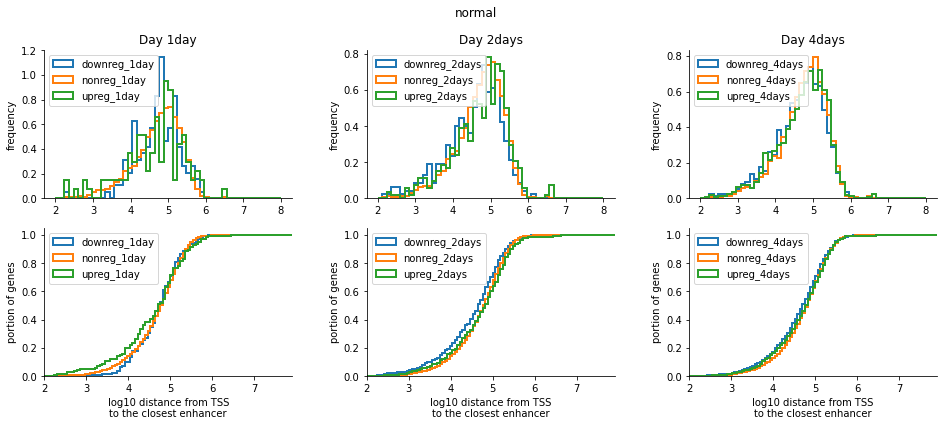

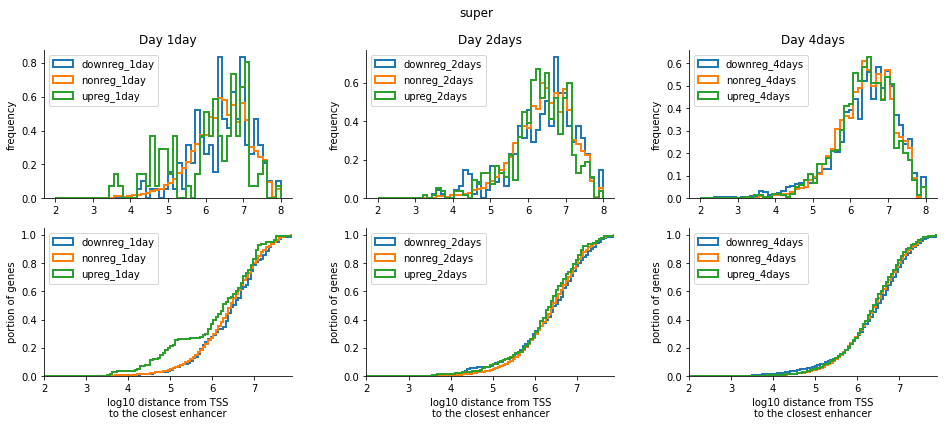

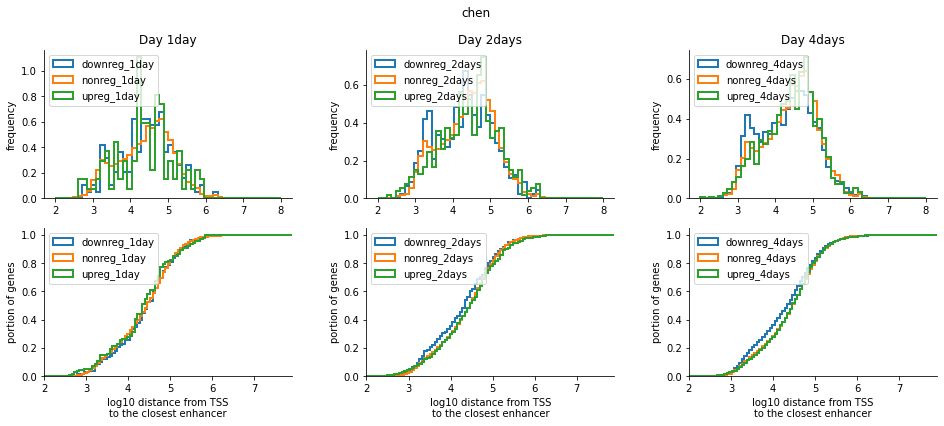

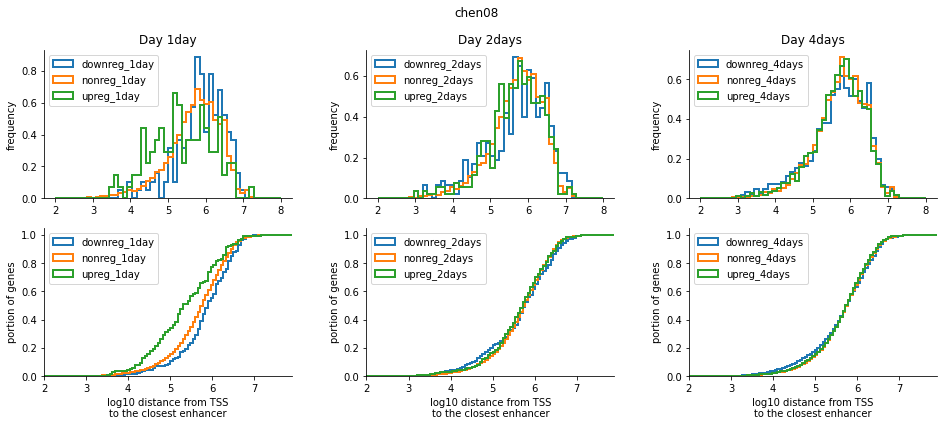

In [57]:
import seaborn as sns
from matplotlib import gridspec
for enh_label in distances:
    plt.figure(figsize=(16,6))
    gs = gridspec.GridSpec(2,3, wspace=0.3)
    plt.suptitle(enh_label)
    for i, day in enumerate(day_list):
        
        plt.subplot(gs[0,i])
        plt.title('Day '+ day)
        
        keys = [k for k in sorted(distances[enh_label].keys()) if k.endswith(day)]
        for k in keys:
            d=distances[enh_label][k]
            _=plt.hist(
                np.log10(d),
                range =(2,8),
                bins=50,
                density=True,
                histtype='step',
                lw=2.0,
                label=k
            )
        plt.legend(loc='upper left')
        plt.ylabel('frequency')
        sns.despine()


        plt.subplot(gs[1,i])
        for k in keys:
            d=distances[enh_label][k]
            _=plt.hist(
                np.log10(d),
                range =(2,8),
                bins=100,
                density=True,
                #normed=True,
                histtype='step',
                lw=2.0,
                cumulative=True,
                label=k
                )
        plt.xlabel('log10 distance from TSS\nto the closest enhancer'.format(enh_label))
        plt.ylabel('portion of genes')
        plt.legend(loc='upper left')
        plt.ylim(0,1.05)
        plt.xlim(2,7.9)
        sns.despine()
    plt.savefig('./nora2017-enh-TSS-pairs-vs-regulation-vs-distance-{}.pdf'.format(enh_label))

In [47]:
#load kallisto counts for mm9
prefix_kallisto= '/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/'
rnaseq_kallisto = pd.read_csv(prefix_kallisto+'deseq-mm9-results/pairwise_deseq_wt_CTCF_AID_auxin1day.csv')
rnaseq_kallisto.rename(columns={'Unnamed: 0':'gene_id'}, inplace=True)
#load relevant TSS list
ensembl_tss_df = read_gtf('/project/fudenber_735/genomes/mm9/ensembl/tsses.gtf')
ensembl_tss_df.rename(columns={'seqname':'chrom'},inplace=True)
ensembl_tss_df.drop_duplicates(['gene_id'], inplace=True)
ensembl_tss_df['chrom'] = 'chr'+ensembl_tss_df['chrom']
ensembl_tss_df[0:4]

day_list = ['1day','2days','4days']
padj_threshold = 0.5
rnaseq_kallisto = []
use_fpkm_mask_kallisto = True

for day in day_list:
    k = pd.read_csv(prefix_kallisto+
            f'deseq-mm9-results/pairwise_deseq_wt_CTCF_AID_auxin{day}.csv')
    k.rename(columns={'Unnamed: 0':'gene_id','log2FoldChange':f'FC.{day}.1','baseMean':f'base.{day}'}, inplace=True)
    k[f'reg{day}'] = 'nonreg'
    k[f'reg{day}'].loc[(k['padj'] < padj_threshold) & (k[f'FC.{day}.1'] > 1.0 )] = 'upreg'
    k[f'reg{day}'].loc[(k['padj'] < padj_threshold )  & (k[f'FC.{day}.1'] < 1.0 )] = 'downreg'
    if day_list.index(day)==0:
        rnaseq_kallisto = k.copy()
    else:
        rnaseq_kallisto = rnaseq_kallisto.merge(
            k[['gene_id',f'base.{day}',f'reg{day}',f'FC.{day}.1']], 
            how ='left',on='gene_id')
rnaseq_kallisto = rnaseq_kallisto.merge( ensembl_tss_df, how='left', on='gene_id')


fpkm1mask_kallisto.sum(), rnaseq_kallisto.shape

/home1/fudenber/.conda/envs/cooltools-pip-env/lib/python3.7/site-packages/gtfparse/read_gtf.py:154: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  features=features)
/home1/fudenber/.conda/envs/cooltools-pip-env/lib/python3.7/site-packages/gtfparse/read_gtf.py:154: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  features=features)
INFO:root:Extracted GTF attributes: ['transcript_id', 'gene_id']
/home1/fudenber/.conda/envs/cooltools-pip-env/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


(19128, (19128, 23))

In [51]:
# collecting then plotting kallisto distances
use_fpkm_mask_kallisto = True
if use_fpkm_mask_kallisto:
    fpkm1mask_kallisto = rnaseq_kallisto['base.1day'].values > 1  #100
else:
    fpkm1mask_kallisto = np.ones(np.shape(rnaseq_kallisto['base.1day'].values ))

all_distances = rec_dd()
distances = rec_dd()
down_distances = rec_dd()
up_distances = rec_dd()
for day in day_list: 
    print(day)
    for enh_label, enh in {'normal':normenh, 'super':superenh, 'chen':chenEnh, 'chen08':chenEnh08}.items():
        for reg_status in ['upreg', 'downreg','nonreg']:
            df1 = rnaseq_kallisto[['chrom','start','end','strand','gene_id']][
                fpkm1mask_kallisto & 
                (rnaseq_kallisto['reg'+day]==reg_status)].copy()
            df2 = enh.copy()
            
            distances[enh_label][reg_status+'_'+day] =  bf.closest(df1[['chrom','start','end']], 
                           df2[['chrom','mid','mid2']] ,cols2=['chrom','mid','mid2'])['distance'].values
                

1day
2days
4days


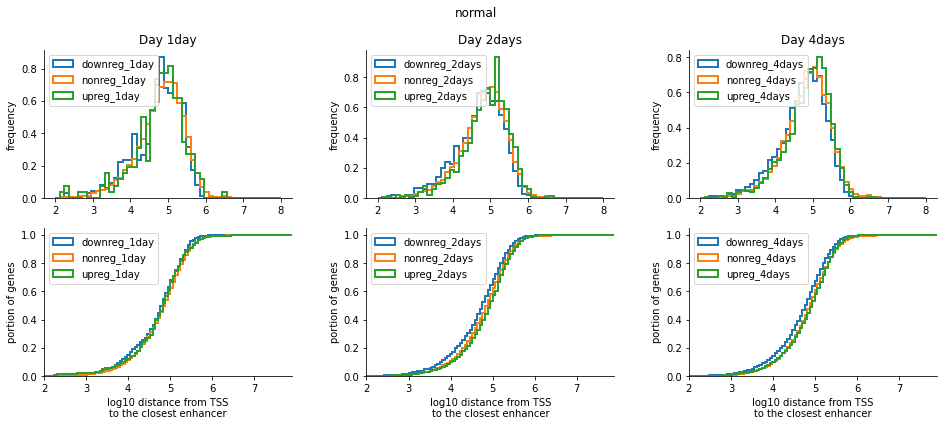

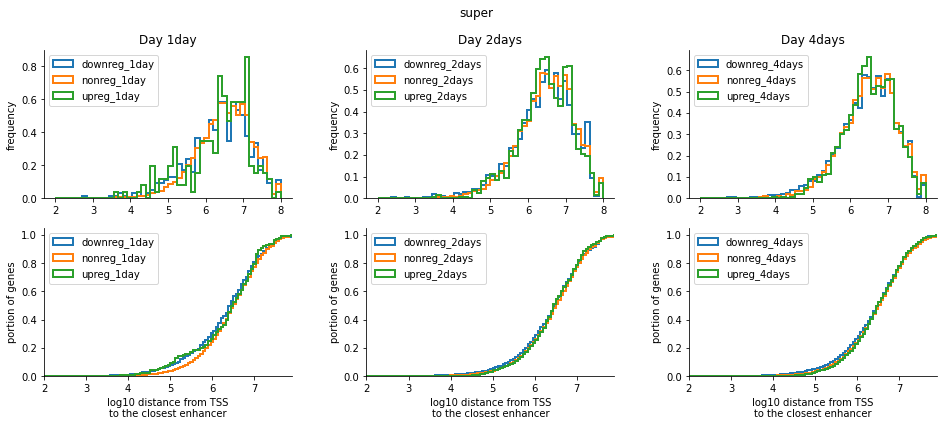

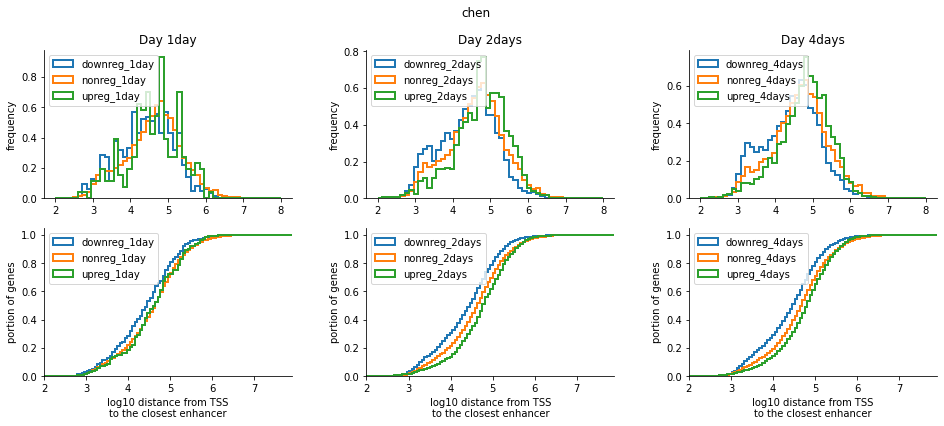

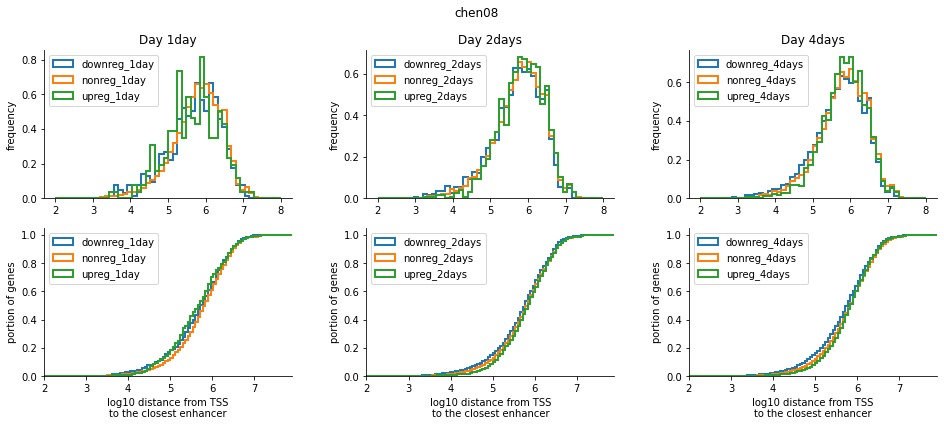

In [52]:
import seaborn as sns
from matplotlib import gridspec
for enh_label in distances:
    plt.figure(figsize=(16,6))
    gs = gridspec.GridSpec(2,3, wspace=0.3)
    plt.suptitle(enh_label)
    for i, day in enumerate(day_list):
        
        plt.subplot(gs[0,i])
        plt.title('Day '+ day)
        
        keys = [k for k in sorted(distances[enh_label].keys()) if k.endswith(day)]
        for k in keys:
            d=distances[enh_label][k]
            _=plt.hist(
                np.log10(d),
                range =(2,8),
                bins=50,
                density=True,
                histtype='step',
                lw=2.0,
                label=k
            )
        plt.legend(loc='upper left')
        plt.ylabel('frequency')
        sns.despine()


        plt.subplot(gs[1,i])
        for k in keys:
            d=distances[enh_label][k]
            _=plt.hist(
                np.log10(d),
                range =(2,8),
                bins=100,
                density=True,
                #normed=True,
                histtype='step',
                lw=2.0,
                cumulative=True,
                label=k
                )
        plt.xlabel('log10 distance from TSS\nto the closest enhancer'.format(enh_label))
        plt.ylabel('portion of genes')
        plt.legend(loc='upper left')
        plt.ylim(0,1.05)
        plt.xlim(2,7.9)
        sns.despine()
    plt.savefig('./kallisto-enh-TSS-pairs-vs-regulation-vs-distance-{}.pdf'.format(enh_label))